# Import

In [1]:
## Imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from scipy.stats import chi2_contingency, pearsonr, spearmanr, mannwhitneyu, f_oneway
from os.path import exists
from importlib import reload

import model
import wrangle
import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook


In [8]:
reload(wrangle)

<module 'wrangle' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/wrangle.py'>

In [9]:
train = wrangle.wrangle_oct(explore=True)

# Explore 

## Univariate

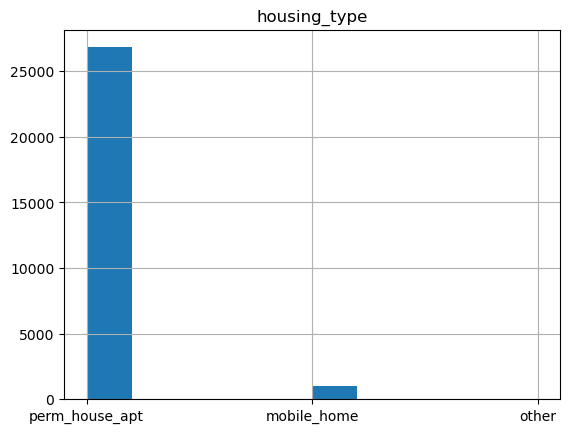

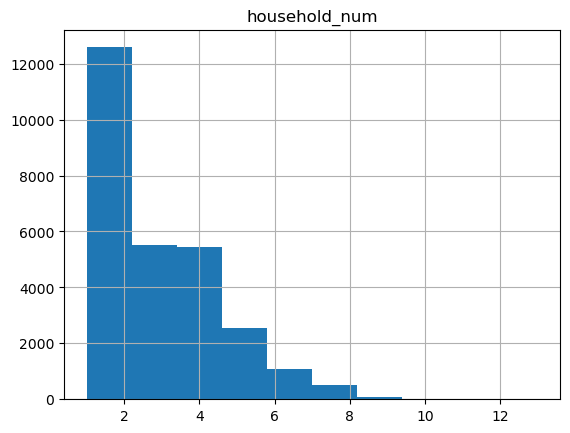

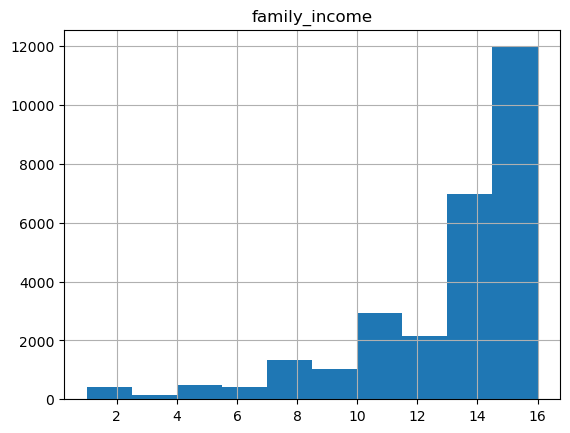

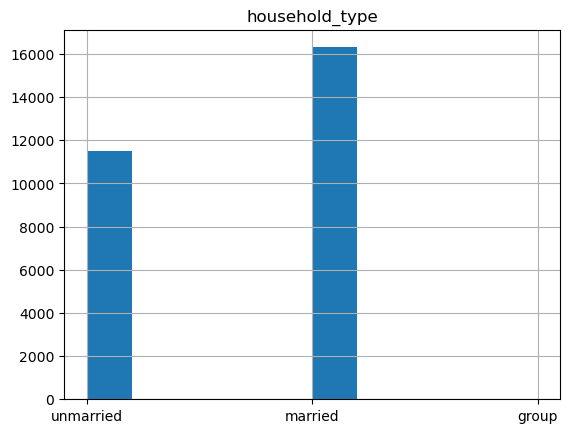

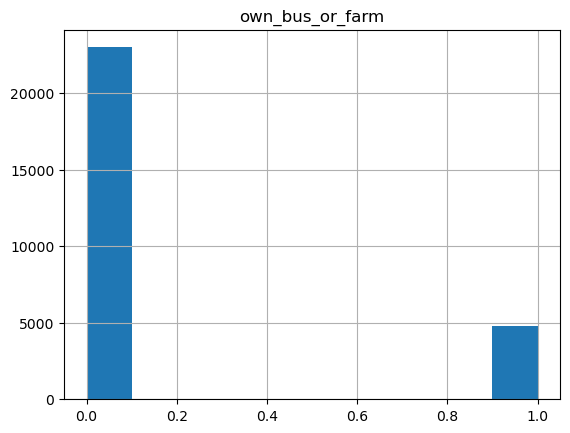

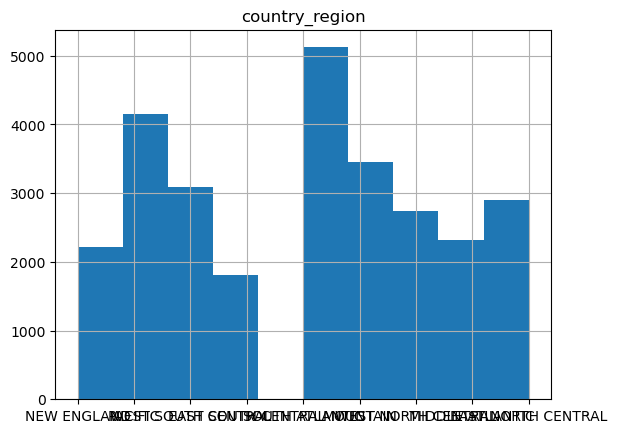

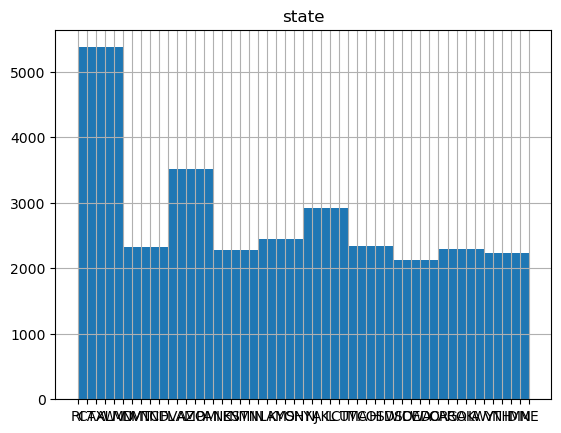

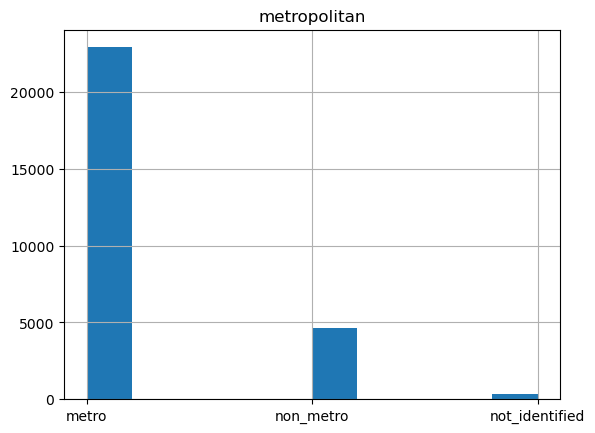

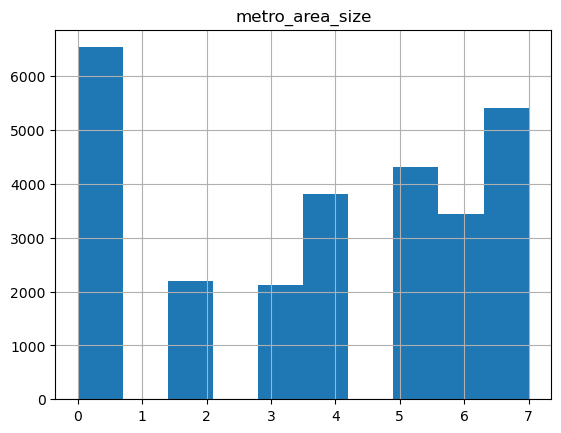

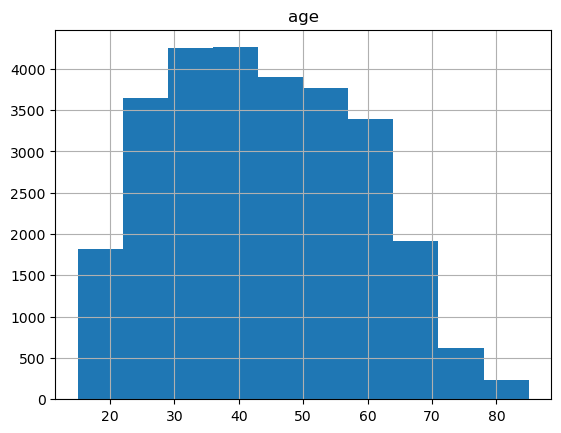

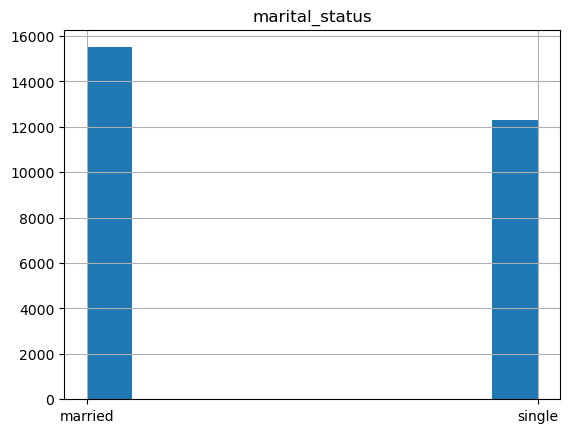

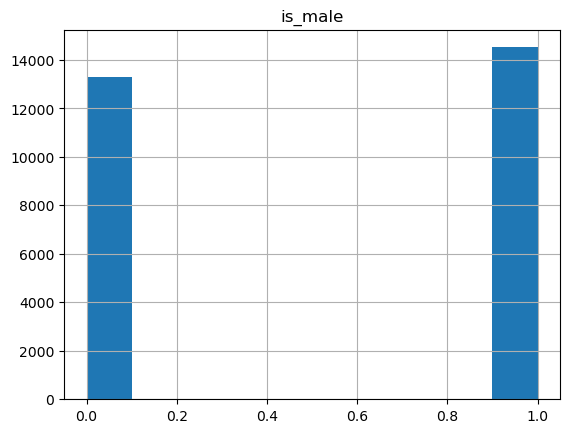

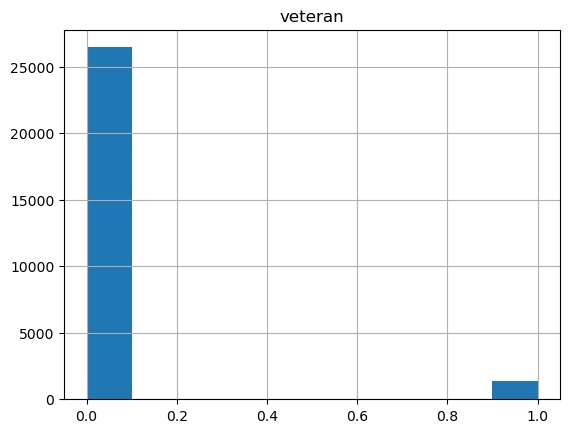

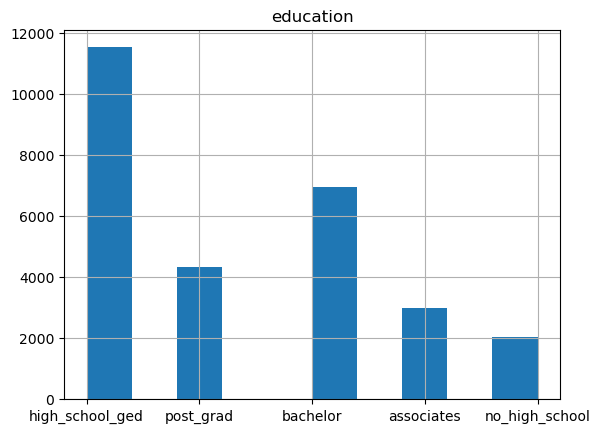

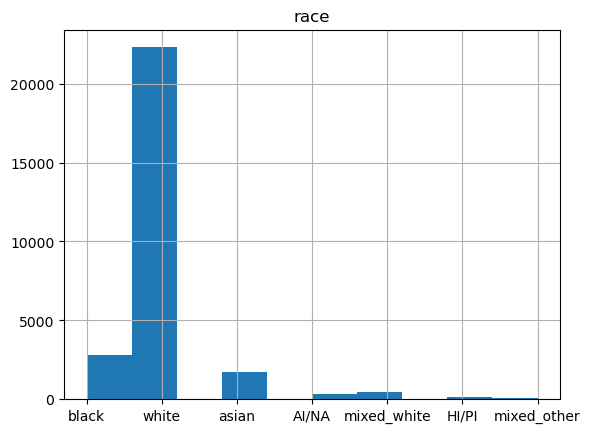

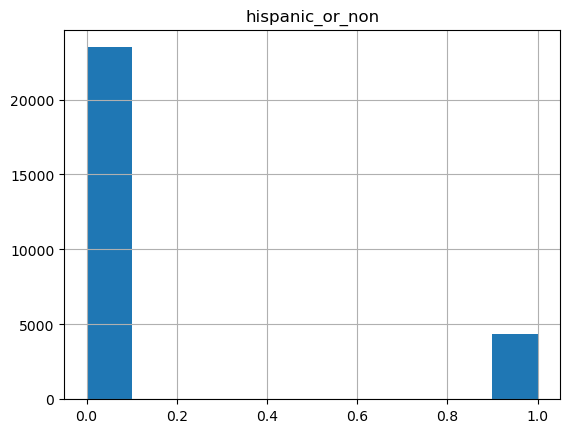

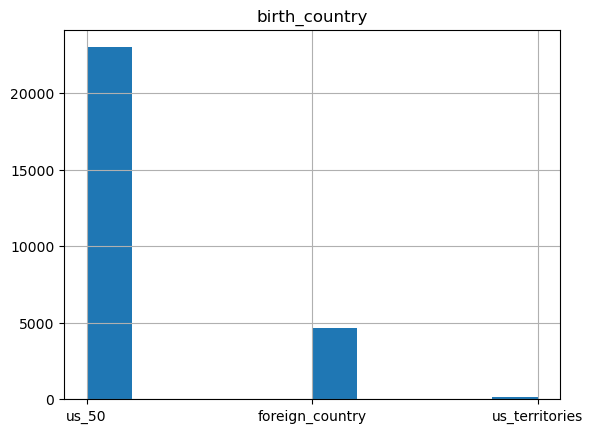

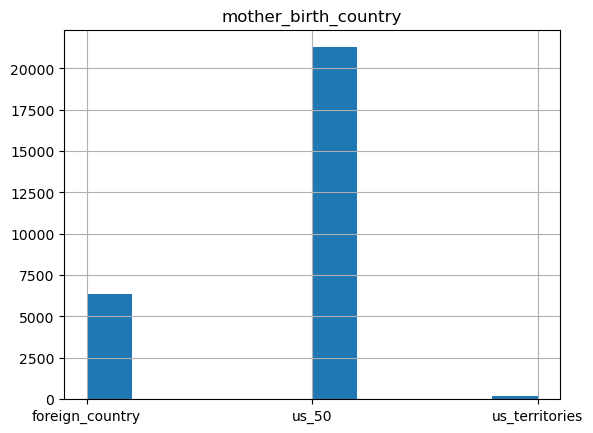

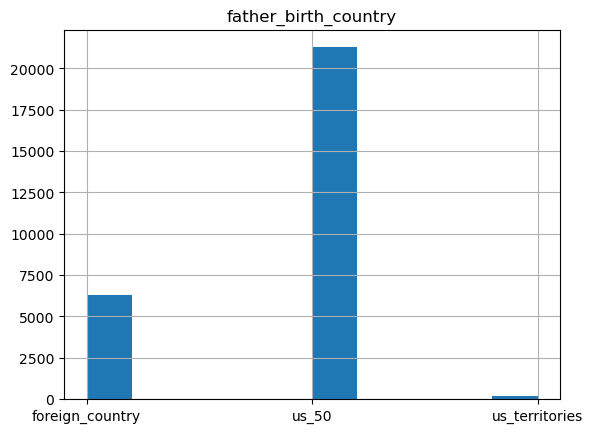

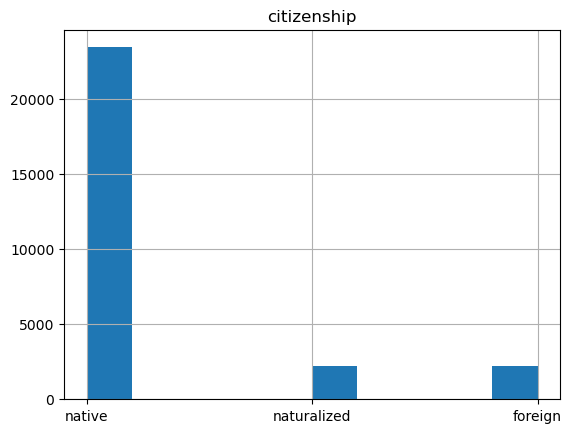

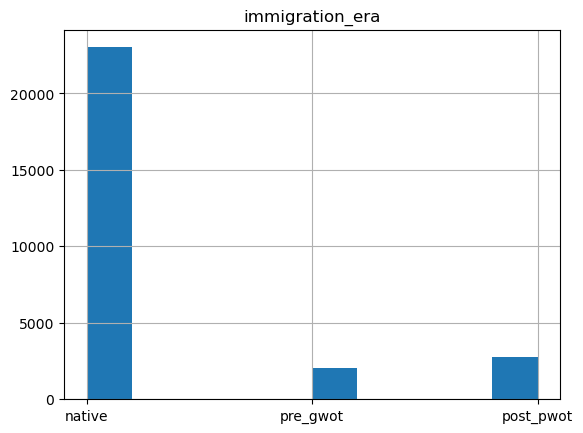

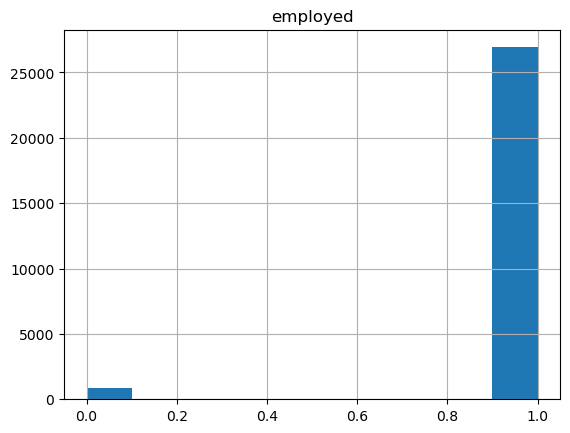

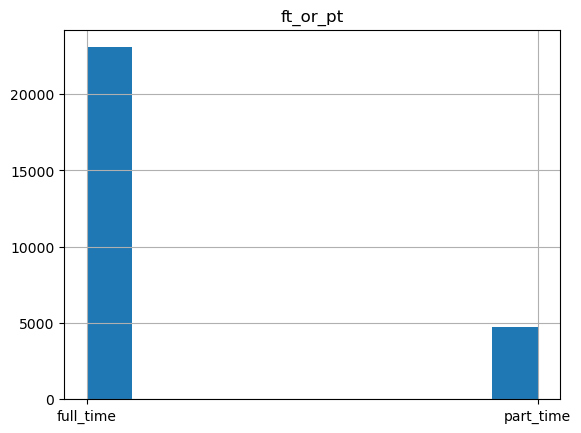

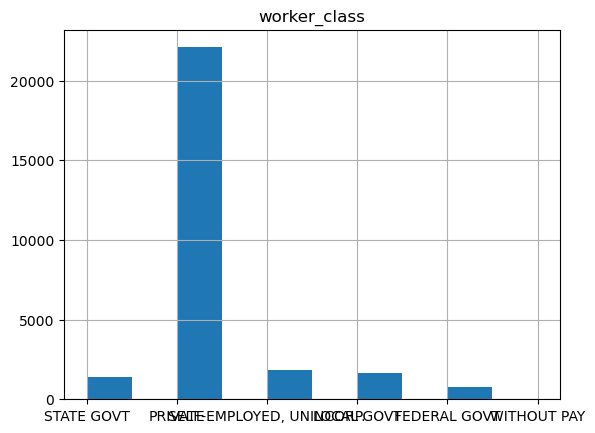

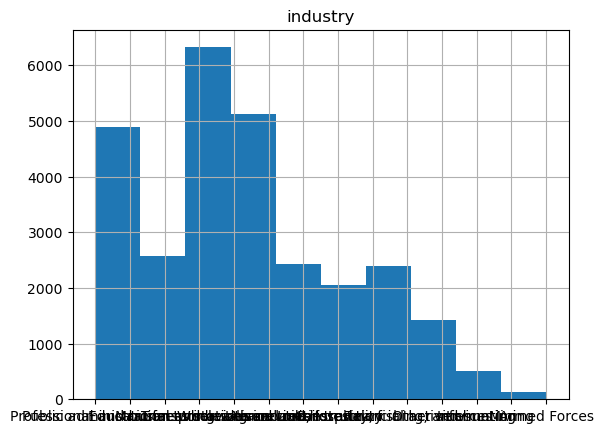

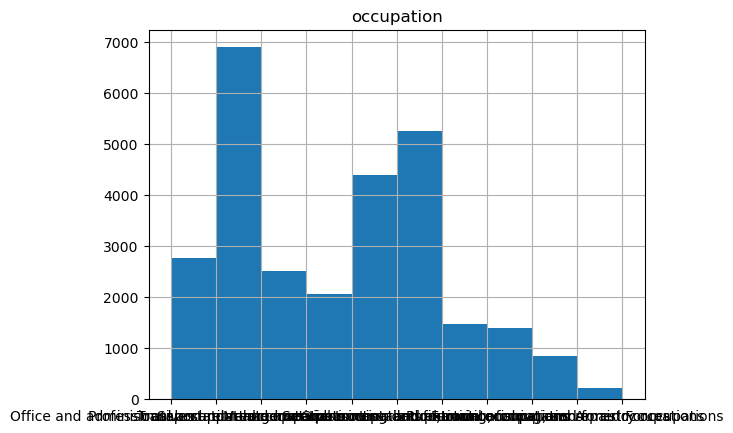

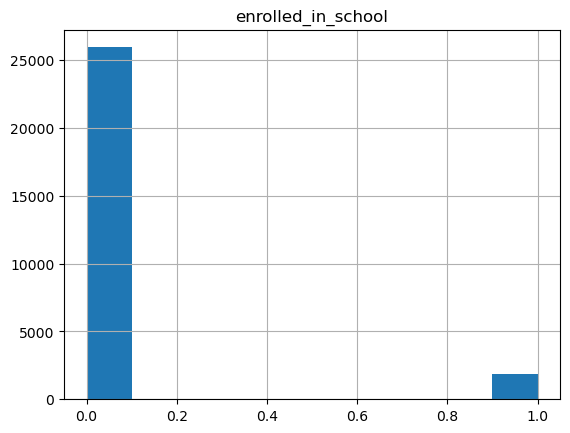

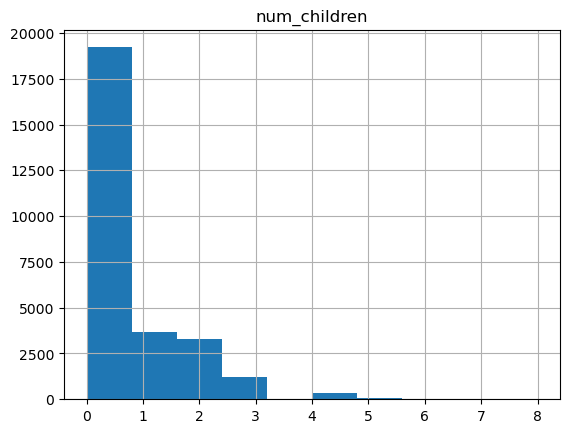

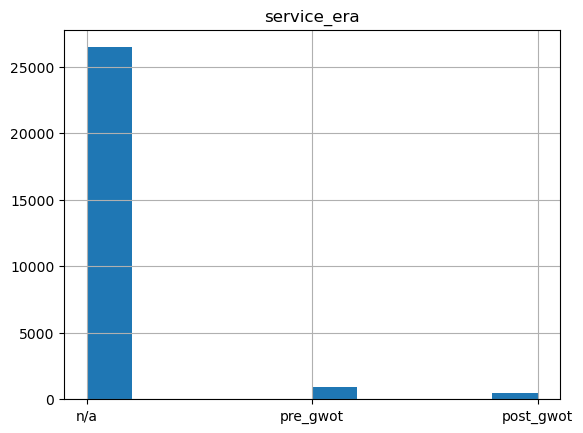

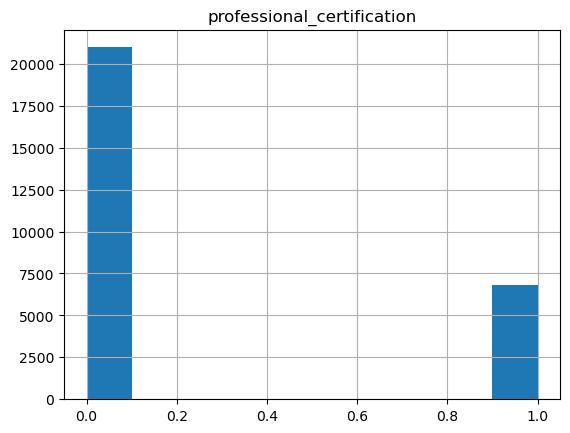

In [10]:
for col in train.columns:
    train[col].hist()
    plt.title(col)
    plt.show()d

### Takeaways
* Skewed:
    - `family_income`, `household_num`, 'household_type`
* many responses from region 5 (south_atlantic)
* almost all respondents worked in last 12 months (train split)
* eliminate - `could_have_started_job`

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [15]:
# create column filter lists for plotting use

#fixing types on categorical columns
categorical_cols = ['housing_type','family_income','household_type',
                'country_region','state','metropolitan','metro_area_size',
                'marital_status','education','race','birth_country',
                'mother_birth_country','father_birth_country','citizenship',
                'industry','occupation']

binary_cols = ['own_bus_or_farm', 'is_male', 'veteran','hispanic_or_non', 
                'employed', 'enrolled_in_school','professional_certification']  

continuous_cols = ['age', 'household_num', 'family_income', 'num_children'] 

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27818 entries, 3549 to 30192
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   housing_type                27818 non-null  object 
 1   household_num               27818 non-null  float64
 2   family_income               27818 non-null  float64
 3   household_type              27818 non-null  object 
 4   own_bus_or_farm             27818 non-null  int64  
 5   country_region              27818 non-null  object 
 6   state                       27818 non-null  object 
 7   metropolitan                27818 non-null  object 
 8   metro_area_size             27818 non-null  float64
 9   age                         27818 non-null  float64
 10  marital_status              27818 non-null  object 
 11  is_male                     27818 non-null  int64  
 12  veteran                     27818 non-null  int64  
 13  education                   

In [16]:
def plot_continuous_pairs (df, col_list):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df[col_list])
    
    #fills out the pairgrid with a regplot
    g.map(sns.regplot, line_kws={'color':'r'})
    return 

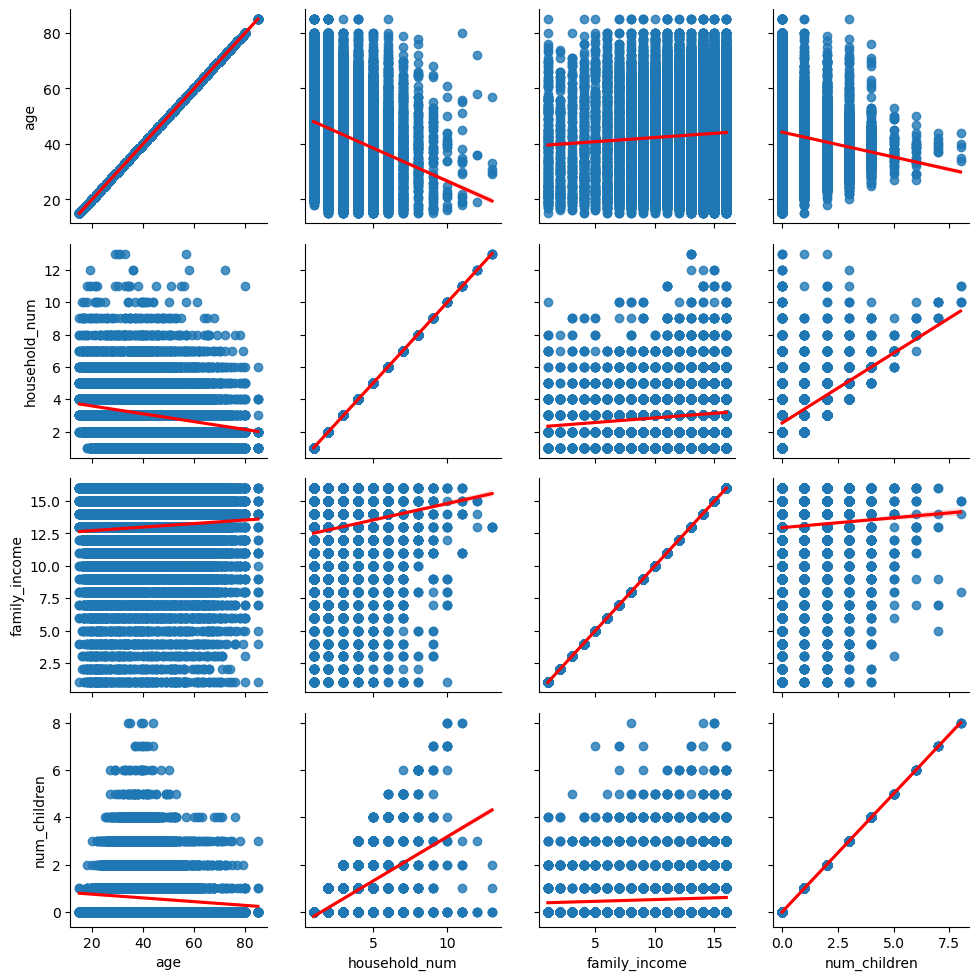

In [17]:
plot_continuous_pairs(train, continuous_cols)

### Takeaways
- Increases in age track with decreases in home size

## Bivariate - Categorical Plotting

In [18]:
unemployed = train[train.employed == 0]
employed = train[train.employed == 1]

In [19]:
unemployed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     15
Armed Forces                                     1
Construction                                    77
Educational and health services                152
Financial activities                            42
Information                                     19
Leisure and hospitality                        149
Manufacturing                                   75
Mining                                           3
Other services                                  34
Professional and business services             109
Public administration                           22
Transportation and utilities                    57
Wholesale and retail trade                     135
dtype: int64

In [20]:
employed.groupby('industry').size()

industry
Agriculture, forestry, fishing, and hunting     534
Construction                                   1974
Educational and health services                6169
Financial activities                           1794
Information                                     481
Leisure and hospitality                        2287
Manufacturing                                  2490
Mining                                          132
Other services                                 1385
Professional and business services             3347
Public administration                          1405
Transportation and utilities                   1620
Wholesale and retail trade                     3310
dtype: int64

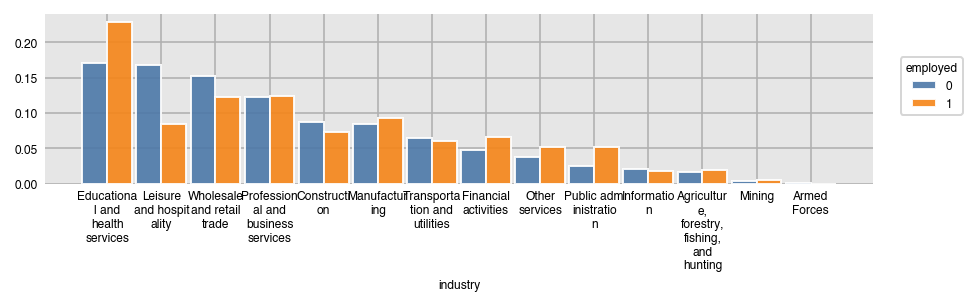

In [21]:
dxp.count('industry', data=train, split='employed', normalize='employed', title='Wholesale/retail and Leisure take up larger share of unemployed that employed')

### Takeaway
    Wholesale/retail and Leisure take up larger share of unemployed that employed

In [31]:
for col in train[categorical_cols]:
    dxp.count('industry', data=train, split='employed', normalize='employed')

### Takeaways
* Look for proportionality differences between employed vs not
* Columns for closer inspection
    - `occupation`, `industry`, `marital_status`, `race` 

### Bivariate - Binary Columns

<Figure size 2000x600 with 0 Axes>

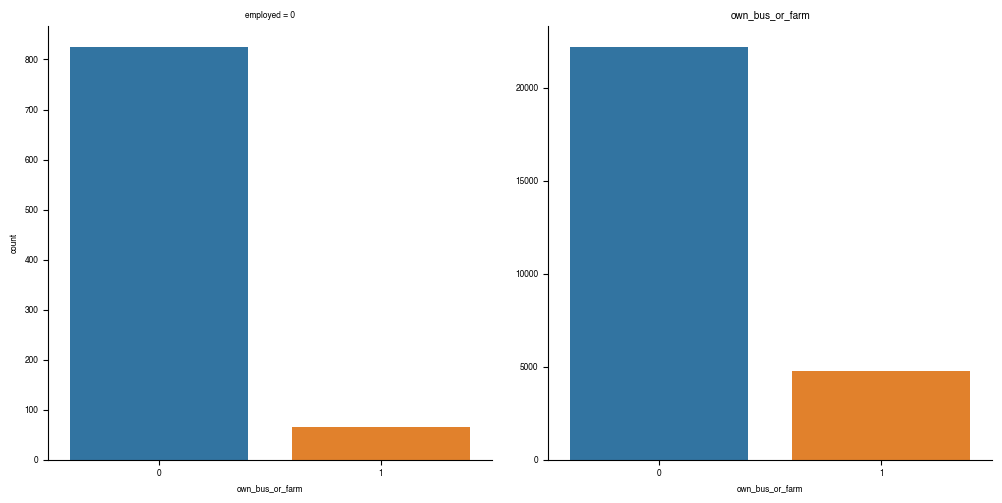

<Figure size 2000x600 with 0 Axes>

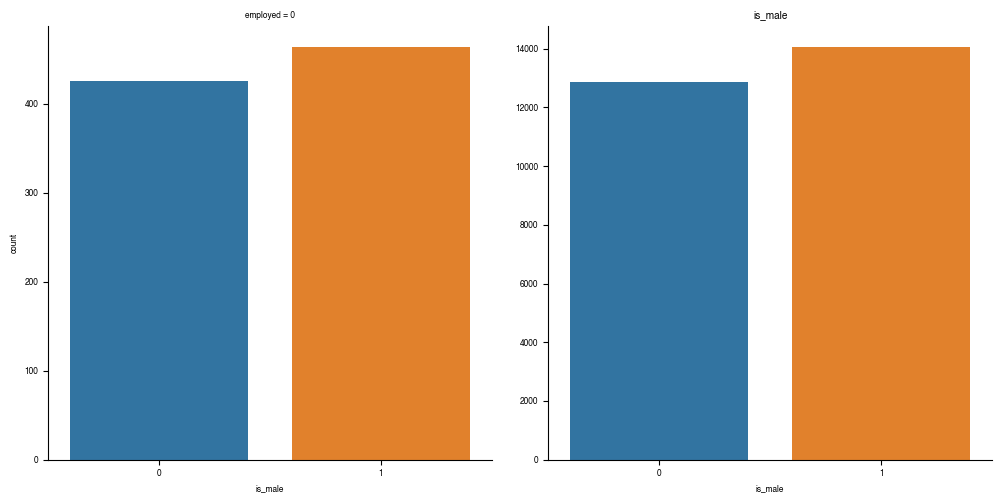

<Figure size 2000x600 with 0 Axes>

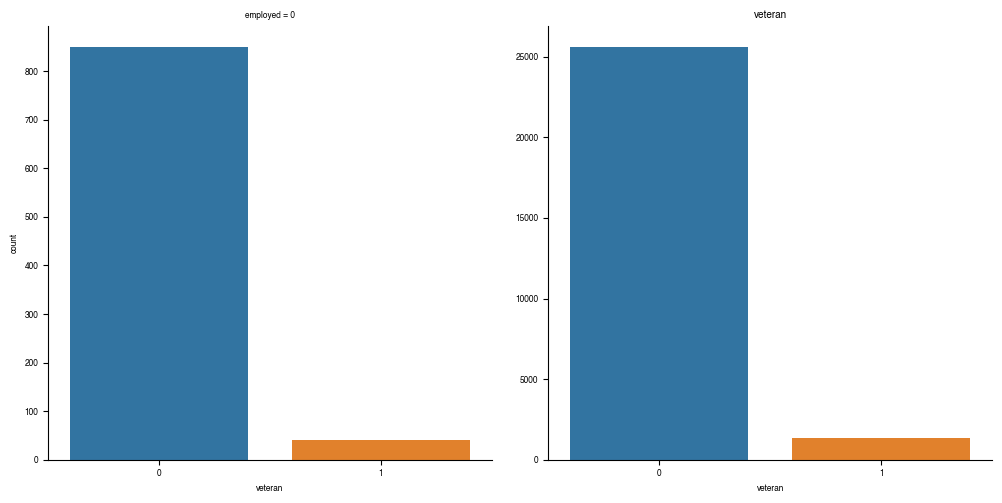

<Figure size 2000x600 with 0 Axes>

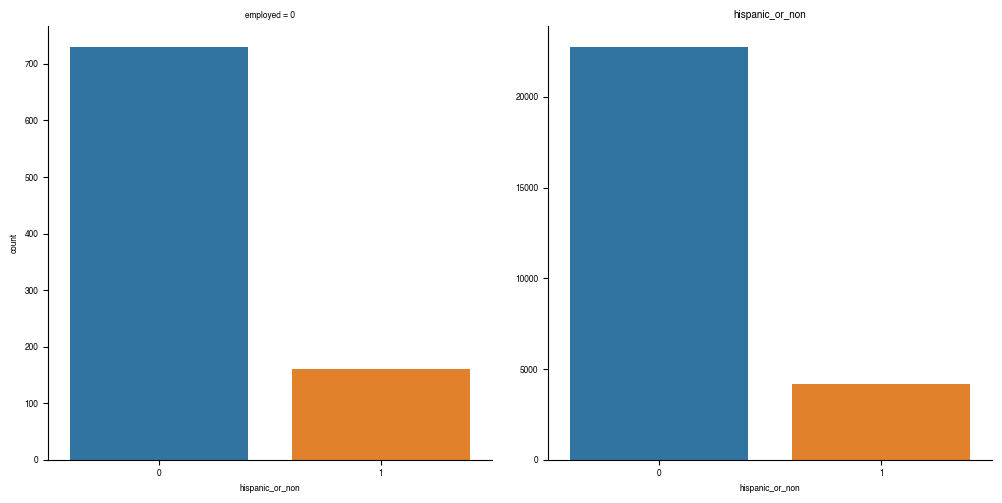

<Figure size 2000x600 with 0 Axes>

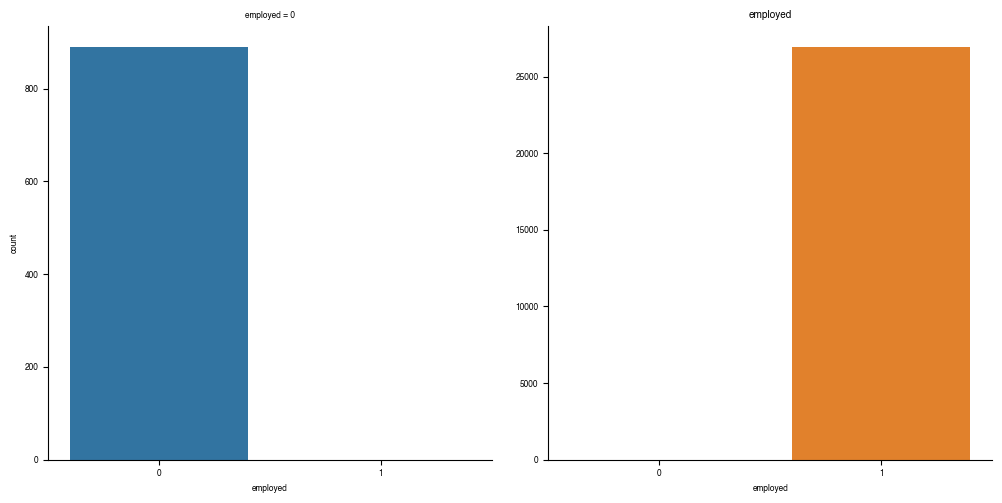

<Figure size 2000x600 with 0 Axes>

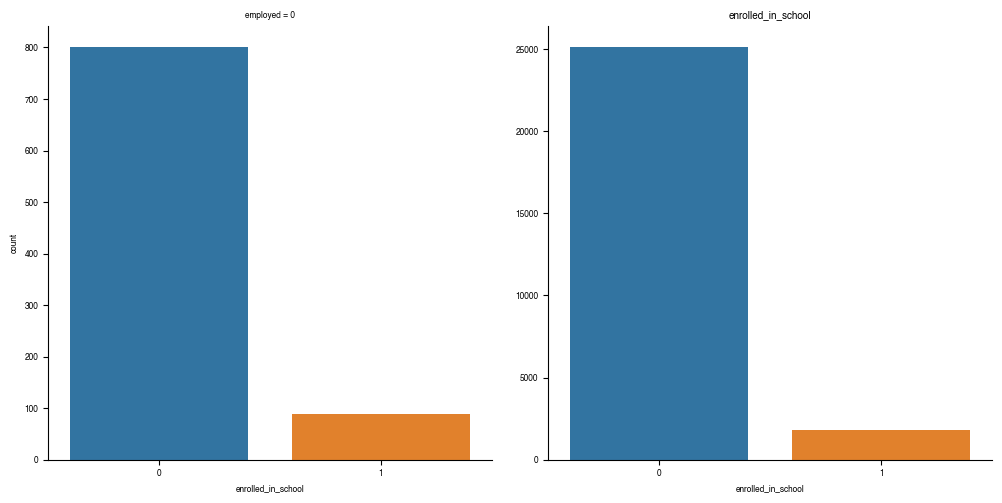

<Figure size 2000x600 with 0 Axes>

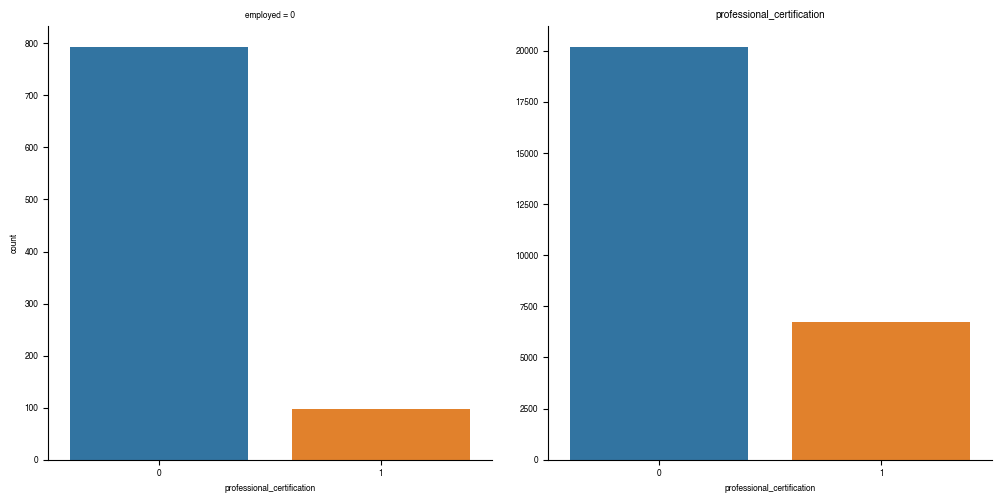

In [32]:
for col in train[binary_cols]:
    plt.figure(figsize=(20,6))
    sns.catplot(data=train, x=col, col='employed', kind='count', sharey=False, orient='y')
    #plt.axhline(y=train.employed.mean(), color='red', linestyle='dashed', label='Employement Percentage')
    plt.title(col)
    plt.show()

### Takeaways
* Gender reversal between employed and not,  change `is_male` --> `is_male` 

* Columns for closer inspection  
    * `professional_certification`  </b>
* Remove columns: `could_have_started_job`, `sought_work_last_12_months`, `worked_last_12_months`, `intend_to_look_next_12_months`, `usual_ot_tips_commis`, `disability_preventing_work_in_next_6_months`  
- all columns not represented at all among employed indivduals. leakage likely  
    
* Drop `metropolitan` and `state`. Adds dimensionality with little gain

## Specific Questions with plots and tests
* Goal:
    Create function for display of unemployment rate and population proportions of column values
* Flow:
    - Chi-2 --> t-test --> feature inclusion
* can bin interesting vs not intersting during feature selection for features the have categories that deviate 

In [33]:
# exported to model.py
from lib2to3.pgen2.pgen import DFAState


def spotlight_stats(df, feature, phase=None):

    multi_col = pd.MultiIndex.from_tuples([('population_proportions', 'employed'), 
                                    ('population_proportions', 'unemployed'),
                                    ('population_proportions', 'change')])
    
    # dataframe, 3 columns, 
    prop_df = pd.DataFrame(columns=multi_col)
    prop_df['unemployment_rate'] = round(1 - train.groupby(by=feature).employed.mean().sort_values(ascending=True), 2)

    # i want to show the proportion of the population that each industry is
    employed_pop_proportion = train[train.employed == 1][feature].value_counts(normalize=True) 

    # i want to show the proportion of the population that each industry is
    unemployed_pop_proportion = train[train.employed == 0][feature].value_counts(normalize=True) 
    
    prop_df[('population_proportions', 'employed')] = employed_pop_proportion
    prop_df[('population_proportions', 'unemployed')] = unemployed_pop_proportion
    prop_df[('population_proportions', 'change')] = employed_pop_proportion - unemployed_pop_proportion

    #chi2
    alpha = .05
    crosstab = pd.crosstab(df[feature], df["employed"])

    chi2, p, dof, expected = chi2_contingency(crosstab)

    if phase == 'explore':
        print('Crosstab\n')
        print(crosstab.values)
        print('---\nExpected\n')
        print(f'{expected.astype(int)}')
        print('---\n')

    print(f'chi^2: {chi2:.4f}')
    print(f'p: {p:.4f}')
    print(f'degrees of freedom: {dof}')

    if p < alpha :
        print('Reject null hypothesis')
    else: 
        print('Fail to reject null hypothesis')

    plt.figure(figsize=(20,6))
    sns.catplot(data=df, x=feature, col='employed', kind='count', sharey=False)
    plt.title(feature)
    plt.show()

    return round(prop_df, 3)

### Spotlight - Industry 
* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between industry of typical employment and employment status   
>* ${H_a}$: There is a relationship between industry of typical employment and employment status  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 140.6777
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

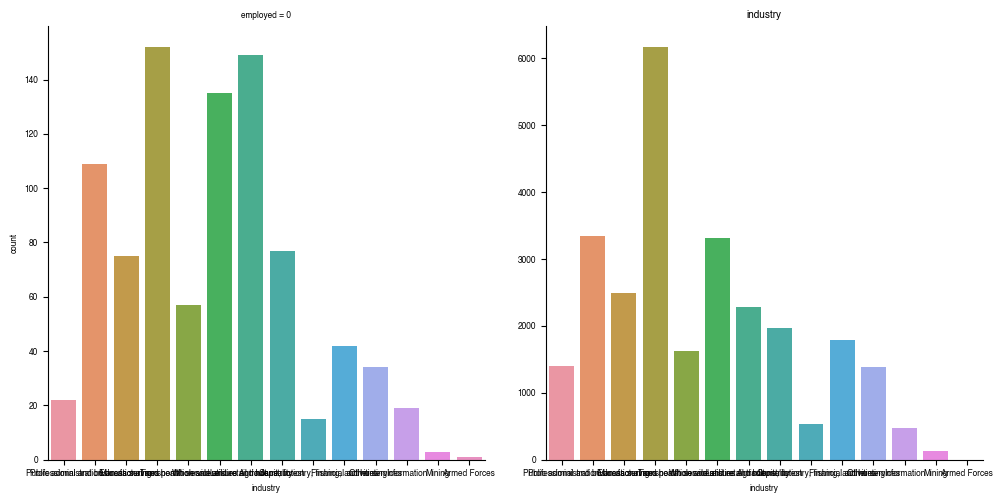

population_proportions             \
                                                          employed unemployed   
industry                                                                        
Armed Forces                                                   NaN      0.001   
Leisure and hospitality                                      0.085      0.167   
Wholesale and retail trade                                   0.123      0.152   
Information                                                  0.018      0.021   
Construction                                                 0.073      0.087   
Transportation and utilities                                 0.060      0.064   
Professional and business services                           0.124      0.122   
Manufacturing                                                0.092      0.084   
Agriculture, forestry, fishing, and hunting                  0.020      0.017   
Educational and health services                              0.229      0.171   
Other services                                               0.051      0.038   
Financial activities                                         0.067      0.047   
Mining                                                       0.005      0.003   
Public administration                                        0.052      0.025   

                                                   unemployment_rate  
                                            change                    
industry                                                              
Armed Forces                                   NaN              1.00  
Leisure and hospitality                     -0.082              0.06  
Wholesale and retail trade                  -0.029              0.04  
Information                                 -0.003              0.04  
Construction                                -0.013              0.04  
Transportation and utilities                -0.004              0.03  
Professional and business services           0.002              0.03  
Manufacturing                                0.008              0.03  
Agriculture, forestry, fishing, and hunting  0.003              0.03  
Educational and health services              0.058              0.02  
Other services                               0.013              0.02  
Financial activities                         0.019              0.02  
Mining                                       0.002              0.02  
Public administration                        0.027              0.02

In [34]:
spotlight_stats(train, 'industry')

#### Statistical Testing

In [37]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['industry'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  15  534]
 [   1    0]
 [  77 1974]
 [ 152 6169]
 [  42 1794]
 [  19  481]
 [ 149 2287]
 [  75 2490]
 [   3  132]
 [  34 1385]
 [ 109 3347]
 [  22 1405]
 [  57 1620]
 [ 135 3310]]
---
Expected

[[  17  531]
 [   0    0]
 [  65 1985]
 [ 202 6118]
 [  58 1777]
 [  15  484]
 [  77 2358]
 [  82 2482]
 [   4  130]
 [  45 1373]
 [ 110 3345]
 [  45 1381]
 [  53 1623]
 [ 110 3334]]
---

chi^2: 140.6777
p: 0.0000
degrees of freedom: 13
Reject null hypothesis


#### Takeaways
>* `Leisure and hospitality` with highest unemployment rate, highest jump in proportionality
>* `Transportaion and utilities` with 2nd highest

### Spotlight - Occupation
>* **Question:** Which occupation shows the largest population proportion change between employed and unemployed?  
>* **Answer:** Farming, Fishing, and Forestry occupations. These occupations also have the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between occupation and employment status  
>* ${H_a}$: There is a relationship between occupation and employment status  
>* ${\alpha}$: .05
>* Result: Reject the null hyptothesis. **Test Code Below**

chi^2: 182.8802
p: 0.0000
degrees of freedom: 10
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

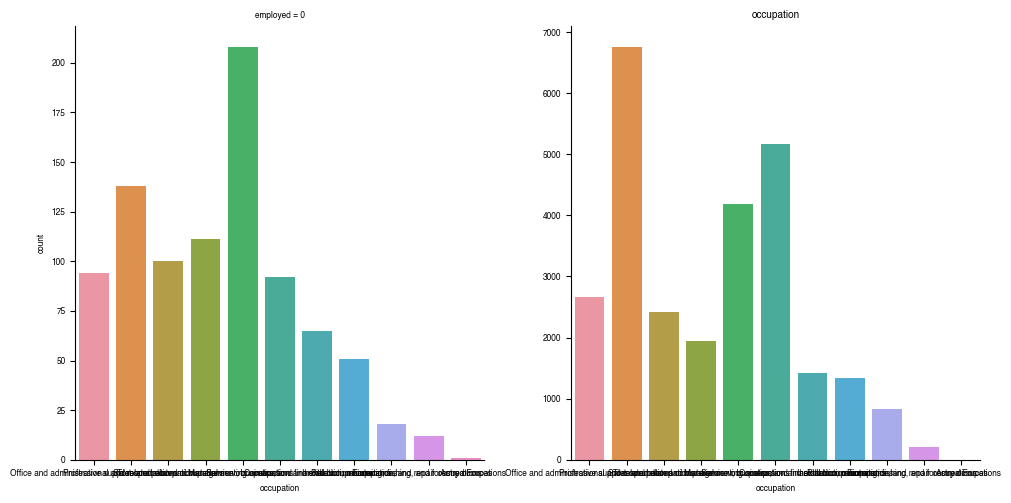

population_proportions  \
                                                                employed   
occupation                                                                 
Armed Forces                                                         NaN   
Transportation and material moving occupations                     0.072   
Farming, fishing, and forestry occupations                         0.008   
Service occupations                                                0.155   
Construction and extraction occupations                            0.053   
Sales and related occupations                                      0.090   
Production occupations                                             0.050   
Office and administrative support occupations                      0.099   
Installation, maintenance, and repair occupations                  0.031   
Professional and related occupations                               0.251   
Management, business, and financial occupations                    0.192   

                                                                     \
                                                  unemployed change   
occupation                                                            
Armed Forces                                           0.001    NaN   
Transportation and material moving occupations         0.125 -0.052   
Farming, fishing, and forestry occupations             0.013 -0.006   
Service occupations                                    0.234 -0.078   
Construction and extraction occupations                0.073 -0.021   
Sales and related occupations                          0.112 -0.023   
Production occupations                                 0.057 -0.008   
Office and administrative support occupations          0.106 -0.006   
Installation, maintenance, and repair occupations      0.020  0.011   
Professional and related occupations                   0.155  0.096   
Management, business, and financial occupations        0.103  0.088   

                                                  unemployment_rate  
                                                                     
occupation                                                           
Armed Forces                                                   1.00  
Transportation and material moving occupations                 0.05  
Farming, fishing, and forestry occupations                     0.05  
Service occupations                                            0.05  
Construction and extraction occupations                        0.04  
Sales and related occupations                                  0.04  
Production occupations                                         0.04  
Office and administrative support occupations                  0.03  
Installation, maintenance, and repair occupations              0.02  
Professional and related occupations                           0.02  
Management, business, and financial occupations                0.02

In [38]:
spotlight_stats(train, 'occupation')

#### Statistical Testing

In [40]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['occupation'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   1    0]
 [  65 1414]
 [  12  214]
 [  18  833]
 [  92 5162]
 [  94 2671]
 [  51 1336]
 [ 138 6756]
 [ 100 2412]
 [ 208 4181]
 [ 111 1949]]
---
Expected

[[   0    0]
 [  47 1431]
 [   7  218]
 [  27  823]
 [ 168 5085]
 [  88 2676]
 [  44 1342]
 [ 220 6673]
 [  80 2431]
 [ 140 4248]
 [  65 1994]]
---

chi^2: 182.8802
p: 0.0000
degrees of freedom: 10
Reject null hypothesis


### Takeways
* Farming fishing and forestry at the top
* service occupations, transportation and material movie tied for 2nd
* service occupations highest change in proportionality

### Spotlight - Marital Status
* **Question:** Which marital status disposition shows the largest population proportion change between employed and unemployed?  
* **Answer:** Single individuals make up a larger share of the unemployed and have an unemployment rate of 5%.

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `marital_status` and `employment` status   
>* ${H_a}$: There is a relationship between `marital_status` and `employment` status  
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 163.8726
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

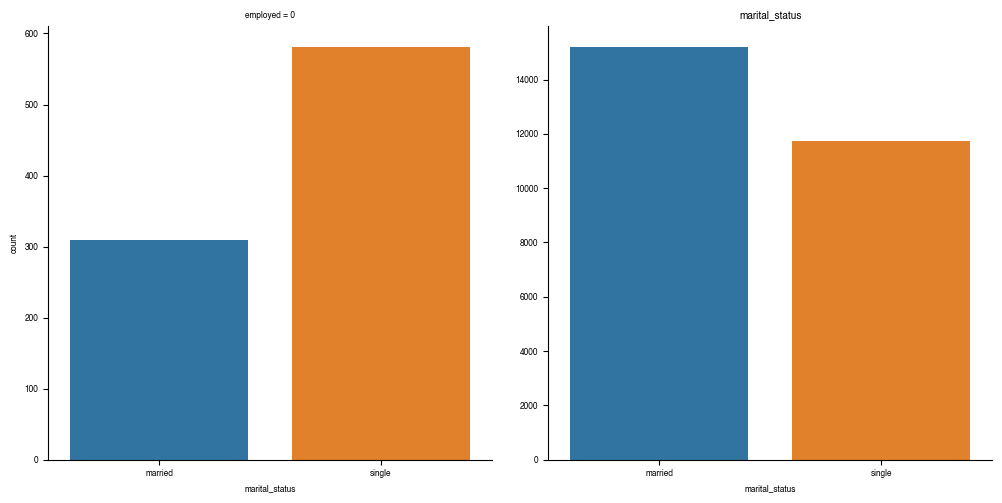

population_proportions                   unemployment_rate
                             employed unemployed change                  
marital_status                                                           
single                          0.436      0.653 -0.217              0.05
married                         0.564      0.347  0.217              0.02

In [41]:
spotlight_stats(train, 'marital_status')

#### Statistical Testing

In [43]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['marital_status'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  309 15198]
 [  581 11730]]
---
Expected

[[  496 15010]
 [  393 11917]]
---

chi^2: 163.8726
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


#### Takeaways
* `single` individuals with highest unemployment rate, highest jump in proportionality

### Spotlight - Race
* **Question:** Which industry shows the largest population proportion change between employed and unemployed?  
* **Answer:** Indivduals identifying as White show the largest population proportion change with a drop of nearly 10% when comparing employed vs unemployed. Those identifying as mixed race other than with white, and Indigenous have the highest unemployed rates at 12% and 7% respectively. 

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between `race` and `employment` status   
>* ${H_a}$: There is a relationship between `race` and `employment` status   
>* ${\alpha}$: .05  
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 102.8163
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

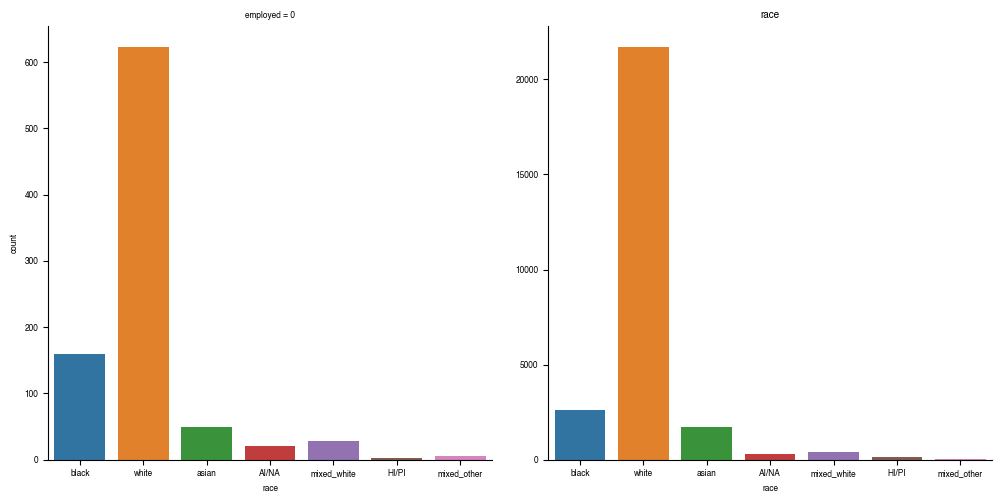

population_proportions                   unemployment_rate
                          employed unemployed change                  
race                                                                  
mixed_other                  0.002      0.006 -0.003              0.08
AI/NA                        0.010      0.024 -0.013              0.07
mixed_white                  0.016      0.033 -0.017              0.06
black                        0.098      0.179 -0.081              0.06
asian                        0.063      0.056  0.007              0.03
white                        0.806      0.700  0.106              0.03
HI/PI                        0.005      0.003  0.001              0.02

In [44]:
spotlight_stats(train, 'race')

#### Statistical Testing

In [46]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['race'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[   21   275]
 [    3   130]
 [   50  1699]
 [  159  2636]
 [    5    61]
 [   29   422]
 [  623 21705]]
---
Expected

[[    9   286]
 [    4   128]
 [   55  1693]
 [   89  2705]
 [    2    63]
 [   14   436]
 [  714 21613]]
---

chi^2: 102.8163
p: 0.0000
degrees of freedom: 6
Reject null hypothesis


#### Takeways
* Mixed raced top of unemployed
* indeginous, black, and hi/pi among tops in unemployment
* black with highest change in proportionality 

### Spotlight - Professional Certification
* **Question:** What is the effect of having a professional certification?  
* **Answer:** Leisure and Hospitality. This industry also has the highest unemployment rate at 6%

#### Statistical Hypothesis
>* ${H_0}$: There is no relationship between having a `professional_certification` and `employment`  
>* ${H_a}$: There is a relationship between having a `professional_certification` and `employment`    
>* ${\alpha}$: .05
>* Result: There is enough evidence to reject our null hypothesis. **Test code below**

chi^2: 92.0426
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

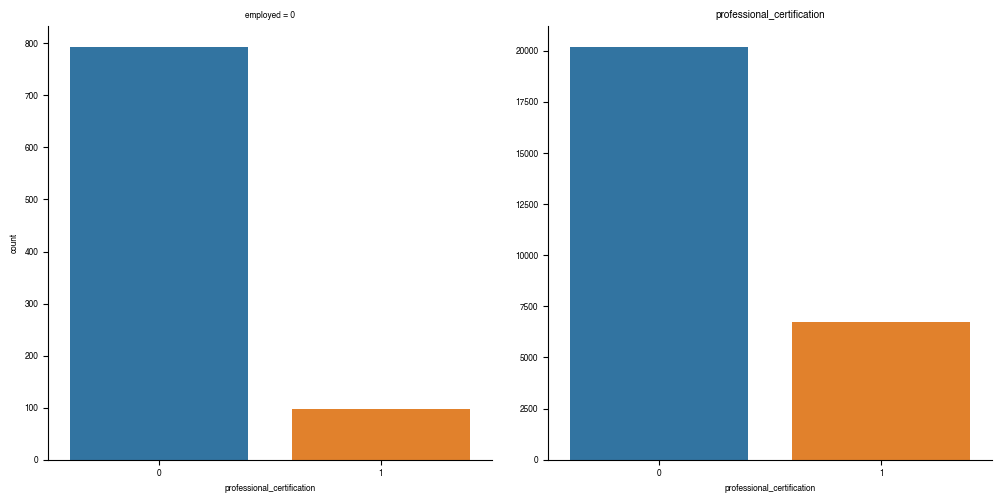

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                            0.75      0.891 -0.141   
1                                            0.25      0.109  0.141   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.01

In [47]:
spotlight_stats(train, 'professional_certification')

#### Statistical Testing

In [49]:
#chi2

alpha = .05

crosstab = pd.crosstab(train['professional_certification'], train["employed"])

chi2, p, dof, expected = chi2_contingency(crosstab)

print('Crosstab\n')
print(crosstab.values)
print('---\nExpected\n')
print(f'{expected.astype(int)}')
print('---\n')
print(f'chi^2: {chi2:.4f}')
print(f'p: {p:.4f}')
print(f'degrees of freedom: {dof}')

if p < alpha :
    print('Reject null hypothesis')
else: 
    print('Fail to reject null hypothesis')


Crosstab

[[  793 20188]
 [   97  6740]]
---
Expected

[[  671 20309]
 [  218  6618]]
---

chi^2: 92.0426
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


#### Takeways
* 4x the unemployment rate for those without a professional_certification

In [50]:
reload(model)

<module 'model' from '/Users/sinao/coding_projects/oct_2022_unemployment_project/model.py'>

chi^2: 92.0426
p: 0.0000
degrees of freedom: 1
Reject null hypothesis


<Figure size 2000x600 with 0 Axes>

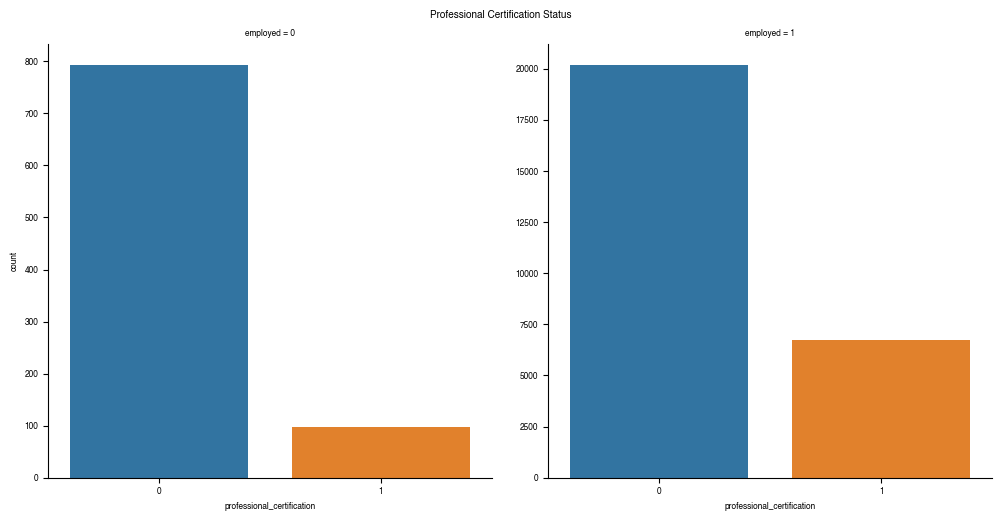

population_proportions                    \
                                         employed unemployed change   
professional_certification                                            
0                                            0.75      0.891 -0.141   
1                                            0.25      0.109  0.141   

                           unemployment_rate  
                                              
professional_certification                    
0                                       0.04  
1                                       0.01

In [51]:
explore.spotlight_stats(train, 'professional_certification', 'Professional Certification Status')

# Exploration Summary
## Key Takeways
* `Leisure and hospitality` with highest industry unemployment rate, highest jump in proportionality
* `service` occupations highest change in proportionality
* `single` individuals with highest unemployment rate, highest jump in proportionality
* `mixed_raced_other` top of unemployed
* `indeginous`, `black`, and `hi/pi` among tops in unemployment rate
* Double the unemployment rate for those without a professional_certification
------------
## Overall Summary
* Overall the conventional wisdom surrounding job prospects held true. 
* It benefits an indvidual to acquire advanced dregrees and certifications
* Having a job or career in an industry that leans more towards being a profession helps
* With more time I want to dive into cross examinations of factors to see how they interact, but I'm doubtful that would help more than simply satisfying my curiousity. 
------------
## Feature Groups for Modeling
* Grouped by subject matter into four clumps in leiu of clustering

* Feature Set 1: `industry`, `occupation`, `country_region`, `metro_area_size` , `professional_certification`, `own_bus_or_farm`,`education`  
    - Chosen to highlight the business oriented concerns around employement
    ---
* Feature Set 2: `household_num`, `children_in_household`, `education`, `enrolled_in_school`, `family_income`, `marital_status`
    - Highlights family and environment characteristics
    ---
* Feature Set 3: `age`, `is_male`, `veteran`, `hispanic_non`, `race`, `birth_country`, `mother_birth_country`, `father_birth_country`, `citizenship`, `education` 
    - Highlights personal characteristics 
    ---
* Feature Set 4: `age`, `industry`, `occupation`,`professional_certification`,`education`,`marital_status`,`is_male`,`citizenship`
    - Highlights area's that may appear on the typical resume or job applicaton